In [20]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

## RoPEの仕組みをつくる
* `inv_freq`：周波数の逆数。次元ごとに異なる周期を持つ
  $$
  \text{inv_freq}_i = \frac{1}{10000^{2i / d}}
  $$
* `positions`：トークンの位置（0, 1, 2, ...）
* `angles = positions × inv_freq`
  → 各位置・各次元ごとに回転角（ラジアン値）を作る
* `cos(angles)` と `sin(angles)` を事前にキャッシュする


## 処理の意味
* `inv_freq`：周波数の逆数。次元ごとに異なる周期を持つ
  $$
  \text{inv_freq}_i = \frac{1}{10000^{2i / d}}
  $$
* `positions`：トークンの位置（0, 1, 2, ...）
* `angles = positions × inv_freq`
  → 各位置・各次元ごとに回転角（ラジアン値）を作る
* `cos(angles)` と `sin(angles)` を事前にキャッシュする

つまり、**各位置に対応する回転行列（cos/sin）を用意**しているのです。

In [2]:
# ==========================================
# 🔹 Rotary Position Embedding (RoPE)
# ==========================================

# 位置に応じた回転角を作る
def build_rope_cache(seq_len, dim):
  half_dim = dim // 2
  freq_seq = torch.arange(half_dim, dtype=torch.float32)
  inv_freq = 1.0 / (10000 ** (freq_seq / half_dim))
  positions = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)
  angles = positions * inv_freq.unsqueeze(0)
  return torch.cos(angles), torch.sin(angles)


In [9]:
dim = 256
seq_len = 64

half_dim = dim // 2
freq_seq = torch.arange(half_dim, dtype=torch.float32)
inv_freq = 1.0 / (10000 ** (freq_seq / half_dim))
positions = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)
angles = positions * inv_freq.unsqueeze(0)

angles


tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 9.3057e-01, 8.6596e-01,  ..., 1.2409e-04, 1.1548e-04,
         1.0746e-04],
        [2.0000e+00, 1.8611e+00, 1.7319e+00,  ..., 2.4819e-04, 2.3096e-04,
         2.1492e-04],
        ...,
        [6.1000e+01, 5.6765e+01, 5.2824e+01,  ..., 7.5697e-03, 7.0442e-03,
         6.5551e-03],
        [6.2000e+01, 5.7695e+01, 5.3690e+01,  ..., 7.6938e-03, 7.1596e-03,
         6.6626e-03],
        [6.3000e+01, 5.8626e+01, 5.4556e+01,  ..., 7.8179e-03, 7.2751e-03,
         6.7700e-03]])

In [13]:
freq_seq / half_dim

tensor([0.0000, 0.0078, 0.0156, 0.0234, 0.0312, 0.0391, 0.0469, 0.0547, 0.0625,
        0.0703, 0.0781, 0.0859, 0.0938, 0.1016, 0.1094, 0.1172, 0.1250, 0.1328,
        0.1406, 0.1484, 0.1562, 0.1641, 0.1719, 0.1797, 0.1875, 0.1953, 0.2031,
        0.2109, 0.2188, 0.2266, 0.2344, 0.2422, 0.2500, 0.2578, 0.2656, 0.2734,
        0.2812, 0.2891, 0.2969, 0.3047, 0.3125, 0.3203, 0.3281, 0.3359, 0.3438,
        0.3516, 0.3594, 0.3672, 0.3750, 0.3828, 0.3906, 0.3984, 0.4062, 0.4141,
        0.4219, 0.4297, 0.4375, 0.4453, 0.4531, 0.4609, 0.4688, 0.4766, 0.4844,
        0.4922, 0.5000, 0.5078, 0.5156, 0.5234, 0.5312, 0.5391, 0.5469, 0.5547,
        0.5625, 0.5703, 0.5781, 0.5859, 0.5938, 0.6016, 0.6094, 0.6172, 0.6250,
        0.6328, 0.6406, 0.6484, 0.6562, 0.6641, 0.6719, 0.6797, 0.6875, 0.6953,
        0.7031, 0.7109, 0.7188, 0.7266, 0.7344, 0.7422, 0.7500, 0.7578, 0.7656,
        0.7734, 0.7812, 0.7891, 0.7969, 0.8047, 0.8125, 0.8203, 0.8281, 0.8359,
        0.8438, 0.8516, 0.8594, 0.8672, 

従来の「位置埋め込み（positional encoding）」では、
単語ベクトルに直接 sin/cos 値を **足し合わせて** いました。

一方、RoPE は **回転操作として組み込む** ことで：

* 相対位置の差（Δpos）をベクトルの**回転角の差**として表現できる
* Attention計算中でも位置差が自然に保存される

つまり、**位置の「差分」がAttentionの内積に直接反映**されるのです。

## 位相の変化の可視化

ヒートマップ（上のグラフ）

縦軸：トークン位置（position）

横軸：周波数成分（embedding の次元）

色：位相（ラジアン値）

→ 右に行くほど「1単語あたりの位相変化が速い（高周波）」になります。
つまり、高次元ほど位置変化に敏感です。

サイン波のプロット（下のグラフ）

dim=0 はゆっくりした波（低周波）

dim=128 は速く振動（高周波）
→ BERTのようなモデルでは、これらが組み合わさって位置情報を表現します。

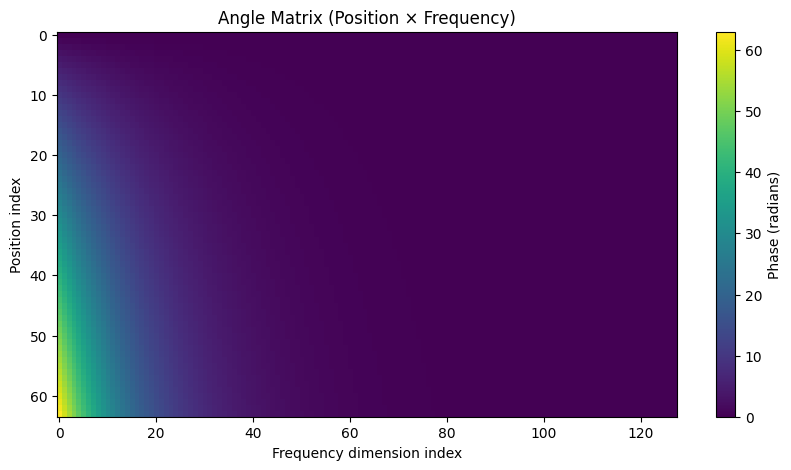

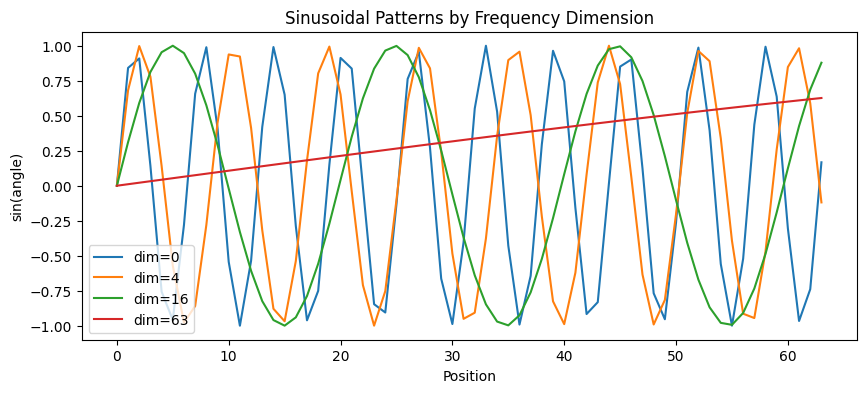

In [11]:
# ==========================================
# 🔹 可視化 1：angles のヒートマップ
# ==========================================
plt.figure(figsize=(10, 5))
plt.imshow(angles.numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label="Phase (radians)")
plt.title("Angle Matrix (Position × Frequency)")
plt.xlabel("Frequency dimension index")
plt.ylabel("Position index")
plt.show()

# ==========================================
# 🔹 可視化 2：いくつかの次元のサイン波を重ね描画
# ==========================================
plt.figure(figsize=(10, 4))
for i in [0, 4, 16, 64]:  # 代表的な周波数成分を抜粋
    plt.plot(positions.squeeze().numpy(), torch.sin(angles[:, i]).numpy(), label=f"dim={i}")

plt.title("Sinusoidal Patterns by Frequency Dimension")
plt.xlabel("Position")
plt.ylabel("sin(angle)")
plt.legend()
plt.show()

In [14]:
def apply_rope(x, cos, sin):
  half_dim = x.shape[-1] // 2
  x1, x2 = x[..., :half_dim], x[..., half_dim:]
  return torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)

In [17]:
# ==========================================
# 🔹 基本設定
# ==========================================
seq_len = 10
embed_dim = 8

Q = torch.randn(seq_len, embed_dim)
K = torch.randn(seq_len, embed_dim)
cos, sin = build_rope_cache(seq_len, embed_dim)
Q_rope = apply_rope(Q, cos, sin)
K_rope = apply_rope(K, cos, sin)

In [21]:
# ==========================================
# 🔹 ① 絶対位置エンコーディング
# ==========================================
def sinusoidal_encoding(seq_len, dim):
    pos = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)
    i = torch.arange(dim, dtype=torch.float32).unsqueeze(0)
    angle_rates = 1 / (10000 ** (2 * (i // 2) / dim))
    angles = pos * angle_rates
    enc = torch.zeros_like(angles)
    enc[:, 0::2] = torch.sin(angles[:, 0::2])
    enc[:, 1::2] = torch.cos(angles[:, 1::2])
    return enc

pos_emb = sinusoidal_encoding(seq_len, embed_dim)
Q_abs = Q + pos_emb
K_abs = K + pos_emb

# Attentionスコア
attn_abs = torch.softmax(Q_abs @ K_abs.T / np.sqrt(embed_dim), dim=-1)